In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf

pd.options.display.max_columns = 999

2024-08-30 10:34:12.784664: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-30 10:34:12.812383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-30 10:34:12.829040: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-30 10:34:12.833821: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-30 10:34:12.846223: I tensorflow/core/platform/cpu_feature_guar

# Loading data sample
Here a example flight

In [5]:
flight = pd.read_csv('/data/common/FUEL_MODEL/data/example_flight.csv')
flight.head()

,timestamp,icao24,callsign,latitude,longitude,altitude,geoaltitude,groundspeed,track,vertical_rate,onground,typecode,registration,operator,track_unwrapped,flight_id,origin,destination,temperature,second,trk,tas,mass,fuelflow
0,2022-01-27 09:40:32+00:00,3985a6,AFR49EH,44.819843,-0.722220,25.0,190.50,152.0,224.733510,2438.179310,0.0,A320,F-HBNG,afr,224.733510,3985a6_3280,LFBD,LFPG,273.582752,0.0,3.922340,142.786999,65450.000000,2957.455859
1,2022-01-27 09:40:36+00:00,3985a6,AFR49EH,44.819843,-0.723659,25.0,213.36,152.0,225.266490,2401.008867,0.0,A320,F-HBNG,afr,225.266490,3985a6_3280,LFBD,LFPG,273.587138,4.0,3.931642,144.268893,65443.427876,2967.727017
2,2022-01-27 09:40:40+00:00,3985a6,AFR49EH,44.819843,-0.726303,175.0,259.08,152.0,225.266490,2363.838424,0.0,A320,F-HBNG,afr,225.266490,3985a6_3280,LFBD,LFPG,274.423492,8.0,3.931642,145.750787,65436.832927,3229.229911
3,2022-01-27 09:40:44+00:00,3985a6,AFR49EH,44.818771,-0.729283,350.0,304.80,153.0,225.530501,2326.667980,0.0,A320,F-HBNG,afr,225.530501,3985a6_3280,LFBD,LFPG,275.397157,12.0,3.936250,147.232680,65429.656860,3182.020020
4,2022-01-27 09:40:48+00:00,3985a6,AFR49EH,44.816849,-0.732030,475.0,342.90,154.0,225.256930,2289.497537,0.0,A320,F-HBNG,afr,225.256930,3985a6_3280,LFBD,LFPG,276.093268,16.0,3.931475,148.714574,65422.585705,3152.676704


# Illustrating speed and altitude parameters

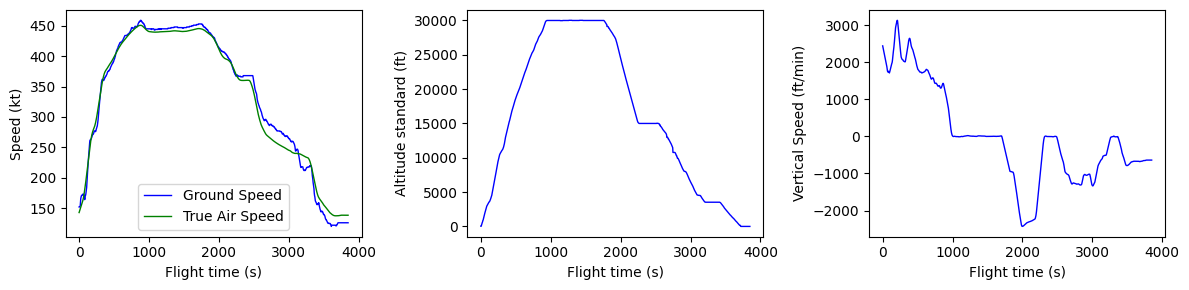

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
ax1.plot(
    flight.second,
    flight.groundspeed,
    color="b",
    lw=1,
    label="Ground Speed",
)

ax1.plot(
    flight.second,
    flight.tas,
    color="g",
    lw=1,
    label="True Air Speed",
)
ax1.legend()
ax1.set_xlabel("Flight time (s)")
ax1.set_ylabel("Speed (kt)")

ax2.plot(flight.second, flight.altitude, color="b", lw=1)
ax2.set_xlabel("Flight time (s)")
ax2.set_ylabel("Altitude standard (ft)")

ax3.plot(flight.second, flight.vertical_rate, color="b", lw=1)
ax3.set_xlabel("Flight time (s)")
ax3.set_ylabel("Vertical Speed (ft/min)")

plt.tight_layout()

# Estimate fuel (with all parameters)

In [11]:
from DeepEnv import FuelEstimator

fe = FuelEstimator()

flight_fuel = fe.estimate(
    flight,
    typecode="typecode",
    groundspeed="groundspeed",
    altitude="altitude",
    vertical_rate="vertical_rate",
    # optional features:
    second="second",
    airspeed="tas",
    mass="mass",
)

ModuleNotFoundError: No module named 'acropole'

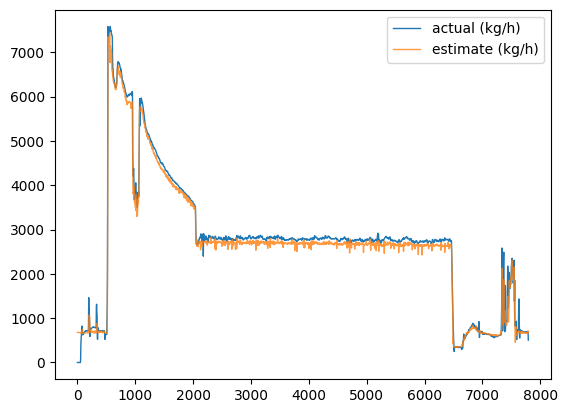

In [5]:
plt.plot(
    flight_fuel.FLIGHT_TIME,
    flight_fuel.FUEL_FLOW_KGH * 2,
    lw=1,
    label="actual (kg/h)",
)
plt.plot(
    flight_fuel.FLIGHT_TIME,
    flight_fuel.fuel_flow_kgh,
    alpha=0.8,
    lw=1,
    label="estimate (kg/h)",
)
plt.legend()

## without mass information

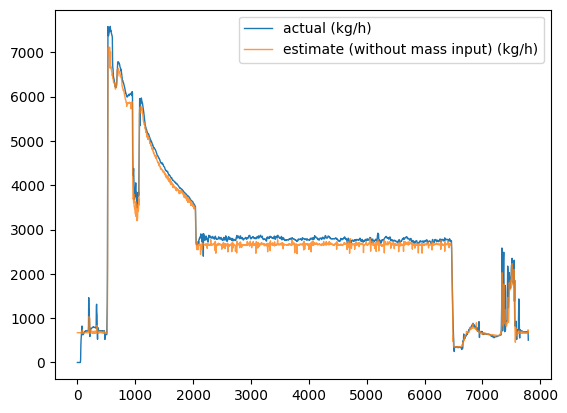

In [6]:
from acropole import FuelEstimator

fr = FuelEstimator()

flight_fuel = fr.estimate(
    flight,
    typecode="FLPL_AIRC_TYPE",
    groundspeed="GRND_SPD_KT",
    altitude="ALTI_STD_FT",
    vertical_rate="VERT_SPD_FTMN",
    # optional features:
    second="FLIGHT_TIME",
    airspeed="TRUE_AIR_SPD_KT",
)

plt.plot(
    flight_fuel.FLIGHT_TIME,
    flight_fuel.FUEL_FLOW_KGH * 2,
    lw=1,
    label="actual (kg/h)",
)
plt.plot(
    flight_fuel.FLIGHT_TIME,
    flight_fuel.fuel_flow_kgh,
    alpha=0.8,
    lw=1,
    label="estimate (without mass input) (kg/h)",
)
plt.legend()
plt.show()

## without mass and airspeed information

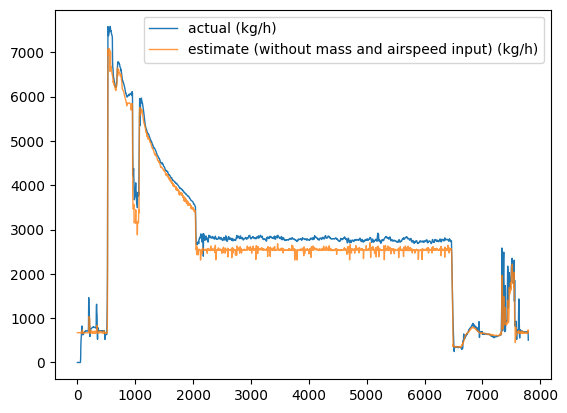

In [7]:
from acropole import FuelEstimator

fr = FuelEstimator()

flight_fuel = fr.estimate(
    flight,
    typecode="FLPL_AIRC_TYPE",
    groundspeed="GRND_SPD_KT",
    altitude="ALTI_STD_FT",
    vertical_rate="VERT_SPD_FTMN",
    # optional features:
    second="FLIGHT_TIME",
)

plt.plot(
    flight_fuel.FLIGHT_TIME,
    flight_fuel.FUEL_FLOW_KGH * 2,
    lw=1,
    label="actual (kg/h)",
)
plt.plot(
    flight_fuel.FLIGHT_TIME,
    flight_fuel.fuel_flow_kgh,
    alpha=0.8,
    lw=1,
    label="estimate (without mass and airspeed input) (kg/h)",
)
plt.legend()
plt.show()

## without mass, airspeed, and time information

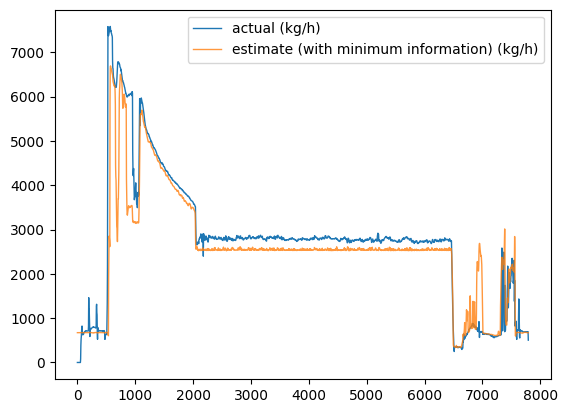

In [8]:
from acropole import FuelEstimator

fr = FuelEstimator()

flight_fuel = fr.estimate(
    flight,
    typecode="FLPL_AIRC_TYPE",
    groundspeed="GRND_SPD_KT",
    altitude="ALTI_STD_FT",
    vertical_rate="VERT_SPD_FTMN",
)

plt.plot(
    flight_fuel.FLIGHT_TIME,
    flight_fuel.FUEL_FLOW_KGH * 2,
    lw=1,
    label="actual (kg/h)",
)
plt.plot(
    flight_fuel.FLIGHT_TIME,
    flight_fuel.fuel_flow_kgh,
    alpha=0.8,
    lw=1,
    label="estimate (with minimum information) (kg/h)",
)
plt.legend()
plt.show()